In [1]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, hog
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
def extract_lbp_feature(image):
    # Implement LBP feature extraction here
    radius = 3
    n_points = 24
    lbp_image = local_binary_pattern(image, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp_image, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist / (lbp_hist.sum() + 1e-6)  # Normalize
    return lbp_hist


In [3]:
def extract_sift_feature(image):
    # Implement SIFT feature extraction here
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    # Flatten the descriptors into a 1-D array
    sift_features = descriptors.flatten()
    return sift_features

In [4]:
def extract_hog_feature(image):
    # Implement HOG feature extraction here
    hog_features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_features

In [5]:
lbp_features_list = []
sift_features_list = []
hog_features_list = []
labels = []  # To store labels (genuine or spoofed)

# Directory containing your images
image_directory = r"C:\Users\Bhargav's\Downloads\Finger\SOCOFing\SOCOFing"

for subdir in os.listdir(image_directory):
    subdir_path = os.path.join(image_directory, subdir)
    
    # Check if it's a directory
    if os.path.isdir(subdir_path):
        label = 1 if subdir.lower() == 'true' else 0  # Genuine images are labeled as 1, spoofed as 0
        
        for filename in os.listdir(subdir_path):
            if filename.endswith(".BMP"):  # Check for BMP files
                image_path = os.path.join(subdir_path, filename)
                
                # Load the image using OpenCV
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                
                # Extract LBP features
                lbp_features = extract_lbp_feature(image)
                lbp_features_list.append(lbp_features)

                # Extract SIFT features
                sift_features = extract_sift_feature(image)
                sift_features_list.append(sift_features)

                # Extract HOG features
                hog_features = extract_hog_feature(image)
                hog_features_list.append(hog_features)
                
                # Append the label
                labels.append(label)


In [6]:
# Determine the number of features in each type
num_lbp_features = len(lbp_features_list[0])
num_sift_features = len(sift_features_list[0])
num_hog_features = len(hog_features_list[0])

In [7]:
print(lbp_features_list[0])

[0.04743123 0.04955502 0.01213592 0.00576456 0.00222492 0.00404531
 0.00232605 0.00303398 0.0049555  0.00566343 0.00546117 0.00788835
 0.00657362 0.01658576 0.00444984 0.0315534  0.00394417 0.01122573
 0.00414644 0.0055623  0.00475324 0.00788835 0.01850728 0.03478964
 0.17586974 0.52366505]


In [8]:
print(sift_features_list[0])

[42.  8.  1. ... 96. 18.  5.]


In [9]:
print(hog_features_list[0])

[0.4881632  0.         0.21091339 ... 0.03195384 0.13110652 0.01386167]


In [10]:
# Ensure that all arrays in the lists have the same number of columns
lbp_features_list = [arr if len(arr) == num_lbp_features else np.zeros(num_lbp_features) for arr in lbp_features_list]
sift_features_list = [arr if len(arr) == num_sift_features else np.zeros(num_sift_features) for arr in sift_features_list]
hog_features_list = [arr if len(arr) == num_hog_features else np.zeros(num_hog_features) for arr in hog_features_list]

In [11]:
# Concatenate the features horizontally
combined_features = np.hstack((lbp_features_list, sift_features_list, hog_features_list))

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(combined_features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
# Initialize and train an SVM classifier
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_val = svm_model.predict(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy (SVM):", accuracy_val)

# Once satisfied with the model, evaluate it on the test set
y_pred_test = svm_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy (SVM):", accuracy_test)

Validation Accuracy (SVM): 0.84
Test Accuracy (SVM): 0.88


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

Confusion Matrix (Validation):
[[64  8]
 [16 62]]
Confusion Matrix (Test):
[[70  8]
 [10 62]]


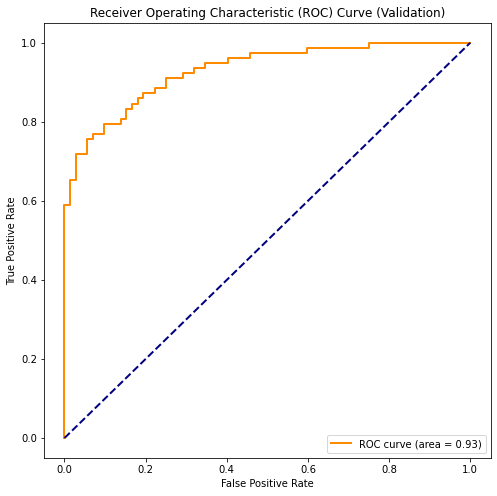

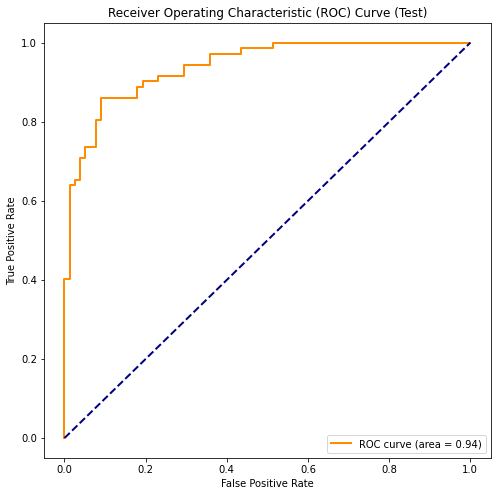

In [14]:
y_prob_val = svm_model.predict_proba(X_val)[:, 1]
y_prob_test = svm_model.predict_proba(X_test)[:, 1]

# Confusion Matrix for Validation Set
cm_val = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix (Validation):")
print(cm_val)

# Confusion Matrix for Test Set
cm_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix (Test):")
print(cm_test)

# Plot ROC Curve for Validation Set
fpr_val, tpr_val, _ = roc_curve(y_val, y_prob_val)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 8))
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_val))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Validation)')
plt.legend(loc="lower right")
plt.show()

# Plot ROC Curve for Test Set
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 8))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Test)')
plt.legend(loc="lower right")
plt.show()

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score

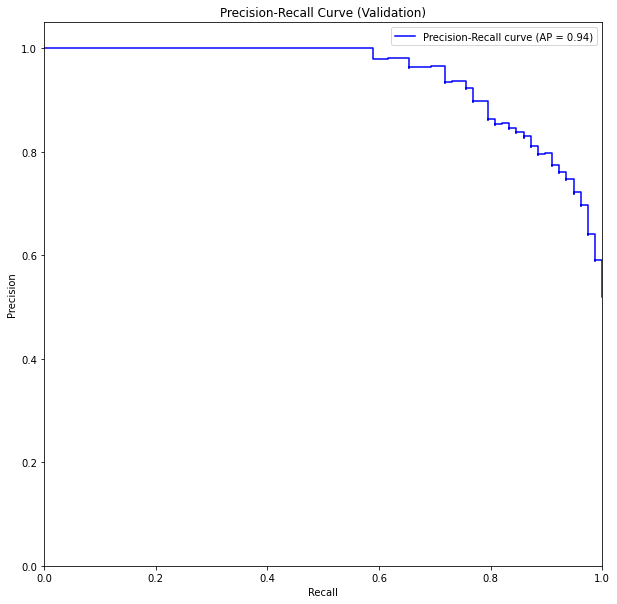

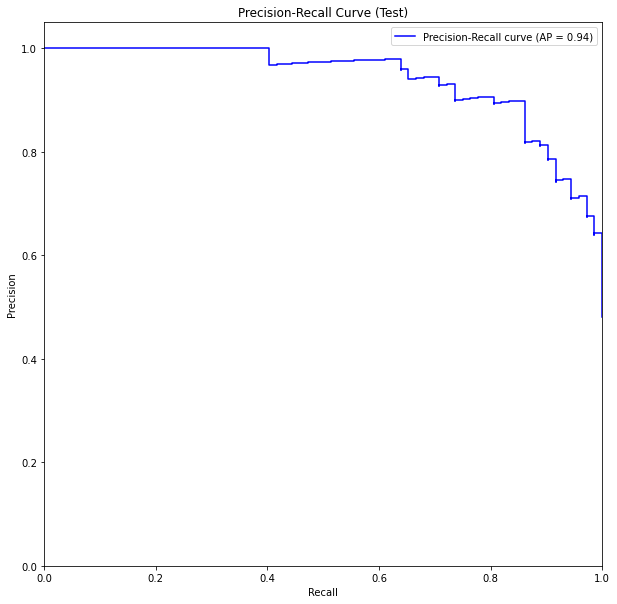

In [16]:
precision_val, recall_val, _ = precision_recall_curve(y_val, y_prob_val)
average_precision_val = average_precision_score(y_val, y_prob_val)

plt.figure(figsize=(10, 10))
plt.step(recall_val, precision_val, color='b', where='post', label='Precision-Recall curve (AP = {:.2f})'.format(average_precision_val))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (Validation)')
plt.legend(loc="upper right")
plt.show()

# Precision-Recall Curve for Test Set
precision_test, recall_test, _ = precision_recall_curve(y_test, y_prob_test)
average_precision_test = average_precision_score(y_test, y_prob_test)

plt.figure(figsize=(10, 10))
plt.step(recall_test, precision_test, color='b', where='post', label='Precision-Recall curve (AP = {:.2f})'.format(average_precision_test))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (Test)')
plt.legend(loc="upper right")
plt.show()

In [17]:
import cv2
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [29]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(combined_features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize and train an SVM classifier
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Get the SVM probabilities for each sample
svm_probabilities_train = svm_model.predict_proba(X_train)[:, 1]
svm_probabilities_val = svm_model.predict_proba(X_val)[:, 1]
svm_probabilities_test = svm_model.predict_proba(X_test)[:, 1]

# Reshape the data for CNN input
X_train_cnn = svm_probabilities_train.reshape(-1, 1)
X_val_cnn = svm_probabilities_val.reshape(-1, 1)
X_test_cnn = svm_probabilities_test.reshape(-1, 1)

# Convert labels to NumPy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Build a simplified CNN model
cnn_model = Sequential()
cnn_model.add(Flatten(input_shape=(1,)))  # Flatten the input
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the CNN model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
history = cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_val_cnn, y_val))

# Evaluate the CNN model on the test set
accuracy_cnn_test = cnn_model.evaluate(X_test_cnn, y_test)[1]
print("Test Accuracy (CNN):", accuracy_cnn_test)

Epoch 1/10
22/22 [==============================] - 1s 20ms/step - loss: 0.6378 - accuracy: 0.7729 - val_loss: 0.6352 - val_accuracy: 0.7000
Epoch 2/10
22/22 [==============================] - 0s 7ms/step - loss: 0.5916 - accuracy: 0.7143 - val_loss: 0.6043 - val_accuracy: 0.7600
Epoch 3/10
22/22 [==============================] - 0s 7ms/step - loss: 0.5475 - accuracy: 0.7643 - val_loss: 0.5752 - val_accuracy: 0.7733
Epoch 4/10
22/22 [==============================] - 0s 7ms/step - loss: 0.5049 - accuracy: 0.8800 - val_loss: 0.5474 - val_accuracy: 0.8067
Epoch 5/10
22/22 [==============================] - 0s 7ms/step - loss: 0.4615 - accuracy: 1.0000 - val_loss: 0.5201 - val_accuracy: 0.8267
Epoch 6/10
22/22 [==============================] - 0s 6ms/step - loss: 0.4170 - accuracy: 1.0000 - val_loss: 0.4926 - val_accuracy: 0.8267
Epoch 7/10
22/22 [==============================] - 0s 7ms/step - loss: 0.3723 - accuracy: 1.0000 - val_loss: 0.4661 - val_accuracy: 0.8333
Epoch 8/10
22/22 [=

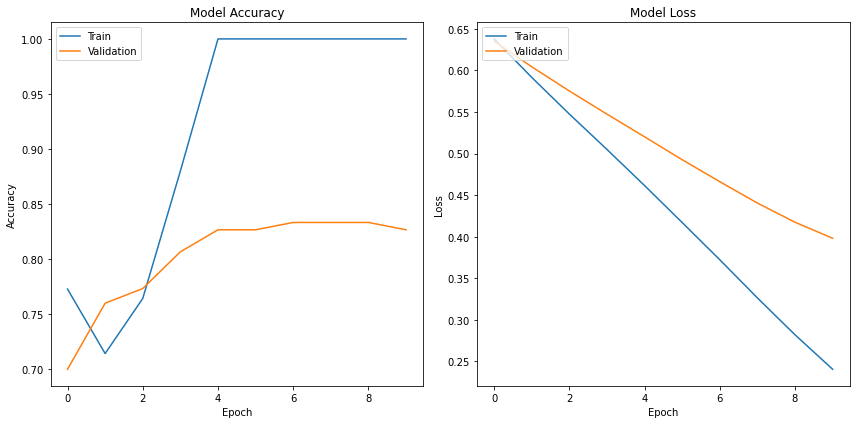

In [30]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()